<a href="https://colab.research.google.com/github/colaresm/COVID-19/blob/main/Aplicando_o_modelo_ARIMA_na_previs%C3%A3o_de_novos_casos_de_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import seaborn as sns
from scipy.stats import skew
import plotly.graph_objects as go
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def mediamovel(dados,janela):
  numbers = dados
  window_size = janela
  numbers_series = pd.Series(numbers)
  windows = numbers_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  return np.round(without_nans,0)
def mediamovel2(dados,janela):
  numbers = dados
  window_size = janela
  numbers_series = pd.Series(numbers)
  windows = numbers_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  return np.round(without_nans,4)
def soma(dados):
  total = []
  a = 0
  for i in range(0,len(dados)):
    a = abs(dados[i])+a
    total.append(a)
  return total

In [5]:
fortaleza = pd.read_csv('/content/drive/MyDrive/datasets_ml/datasetfortaleza.csv')
fortaleza=fortaleza.reindex(index=fortaleza.index[::-1])
fortaleza

,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
382,202012,2020-03-16,1,CE,Fortaleza,2304400,city,8,0.29777,8,0,0,0.0000,2686612,False,False
381,202012,2020-03-17,2,CE,Fortaleza,2304400,city,9,0.33499,1,0,0,0.0000,2686612,False,False
380,202012,2020-03-18,3,CE,Fortaleza,2304400,city,17,0.63277,8,0,0,0.0000,2686612,False,False
379,202012,2020-03-19,4,CE,Fortaleza,2304400,city,17,0.63277,0,0,0,0.0000,2686612,False,True
378,202012,2020-03-20,5,CE,Fortaleza,2304400,city,63,2.34496,46,0,0,0.0000,2686612,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,202113,2021-03-29,379,CE,Fortaleza,2304400,city,156585,5828.34440,0,5909,0,0.0377,2686612,False,True
3,202113,2021-03-30,380,CE,Fortaleza,2304400,city,156585,5828.34440,0,5909,0,0.0377,2686612,False,True
2,202113,2021-03-31,381,CE,Fortaleza,2304400,city,161309,6004.17924,4724,6082,173,0.0377,2686612,False,False
1,202113,2021-04-01,382,CE,Fortaleza,2304400,city,162422,6045.60688,1113,6151,69,0.0379,2686612,True,False


Incialmente vamos verificar o comportamento da série temporal do número diário de novos casos confirmados de COVID-19 em Fortaleza entre 03/2020 e 04/2021.

Text(0, 0.5, 'Novos casos')

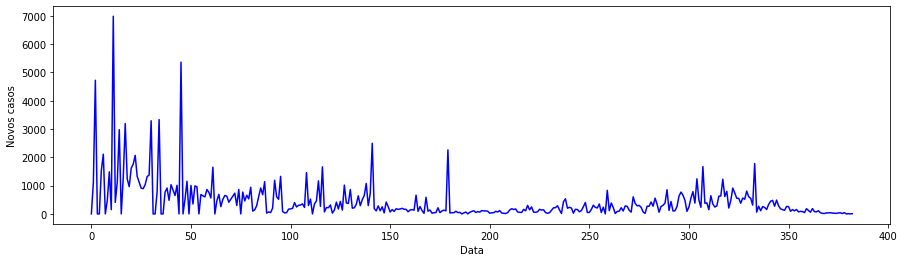

In [6]:
y_real = abs(fortaleza['new_confirmed'] )
plt.figure(figsize=(15,4))
plt.plot(y_real,color='b')
plt.xlabel('Data')
plt.ylabel('Novos casos')

In [7]:
fortaleza.reset_index(inplace=True)
fortaleza['date'] = pd.to_datetime(fortaleza['date'])
fortaleza = fortaleza.set_index('date')
y_real = abs(fortaleza['new_confirmed'] )
series = y_real
result = seasonal_decompose(series, model='additive')

Agora vamos investigar as componentes dessa série tempora, ou seja, vamos observar suas componentes de tendência, sazonal e de ruído considererando uma decomposição aditiva.


*   X(t)- O valor médio da série.
*   T(t)- Tendência
*   S(t)- Sazonal(periódica)
*   N(t)- Ruído(parte aleatória)
<br>
Assim uma série temporal $X(t)$ pode ser decomposta de da seguinte forma aditiva:
$$ Y(t)= X(t)+T(t)+S(t)+N(t)$$

Text(0.5, 1.0, 'Resíduo')

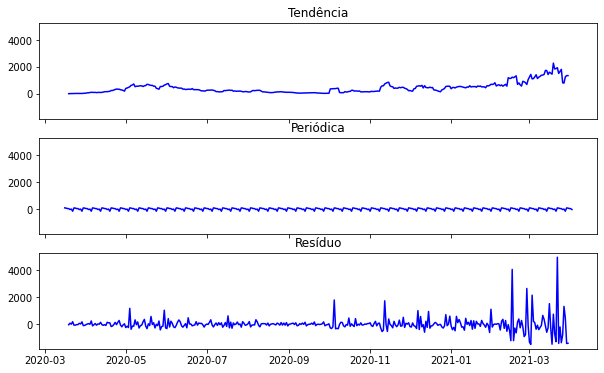

In [8]:
fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(10,6))
#fig.suptitle('Componentes da Série')
axs[0].plot(result.trend,color='b')
axs[0].set_title("Tendência")
axs[1].plot(result.seasonal,color='b')
axs[1].set_title("Periódica")
axs[2].plot(result.resid,color='b')
axs[2].set_title("Resíduo")

Média: -5.515288295611721
Desvio padrão: 532.6694954993014


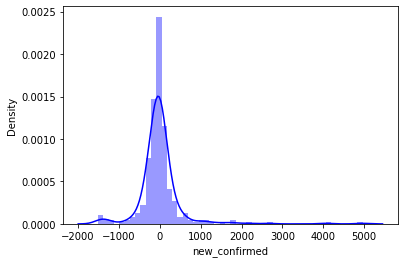

In [9]:
sns.distplot(result.resid,color='b')
print('Média:',np.mean(result.resid))
print('Desvio padrão:',np.std(result.resid))

Conforme é possível observar, a distribuição do resíduo não apresenta uma distribuição próxima a de uma normal, visto que sua média está centrada em aproximadamente -5 e seu desvio padrão é elevado, o que pode ser explicado por represamento de dados clínicos por partes das secretarias de saúde e laboratórios.

Então, diante desse contexto, vamos aplicar o **log** no número de novos casos confirmados somado uma unidade, de modo que não ocorra nenhum problema com a função **log** quando não houverem novos casos confirmados.



In [10]:
y_log = np.log(y_real+1)
result_log = seasonal_decompose(y_log, model='additive')

Text(0.5, 1.0, 'Resíduo')

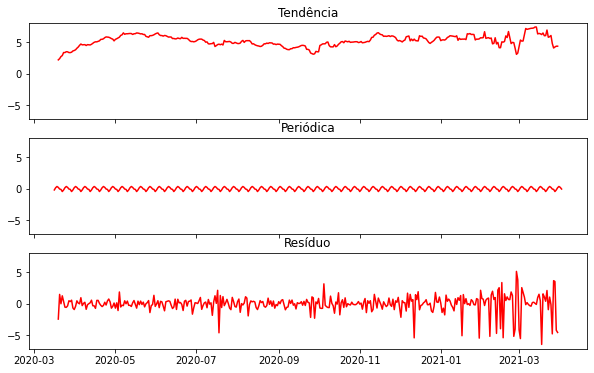

In [11]:
fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(10,6))
#fig.suptitle('Componentes da Série')
axs[0].plot(result_log.trend,color='r')
axs[0].set_title("Tendência")
axs[1].plot(result_log.seasonal,color='r')
axs[1].set_title("Periódica")
axs[2].plot(result_log.resid,color='r')
axs[2].set_title("Resíduo")

Média: -0.01
Desvio padrão: 1.37


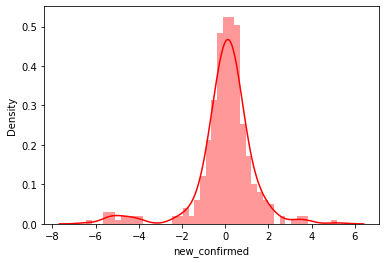

In [12]:
sns.distplot(result_log.resid,color='r')
print('Média:',round(np.mean(result_log.resid),2))
print('Desvio padrão:',round(np.std(result_log.resid),2))

Conforme é possível observar, o resíduo da decomposição da nova série assemelha-se bastante  a uma distribuição normal.

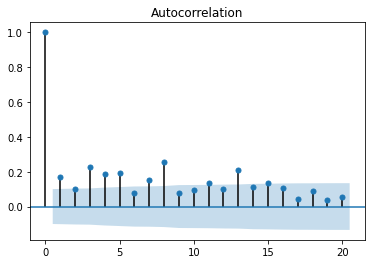

In [13]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(np.log(series+1), lags=20)
plt.show()
 

In [42]:
def arima(dados,p,d,q):
  model = ARIMA(dados,order=(p,d,q)).fit()
  predicao=model.forecast(steps=20)[0]
  fited_values = model.predict(typ='levels')
  return fited_values,predicao

In [43]:
y_pred =  arima(y_log,3,1,2)[0]

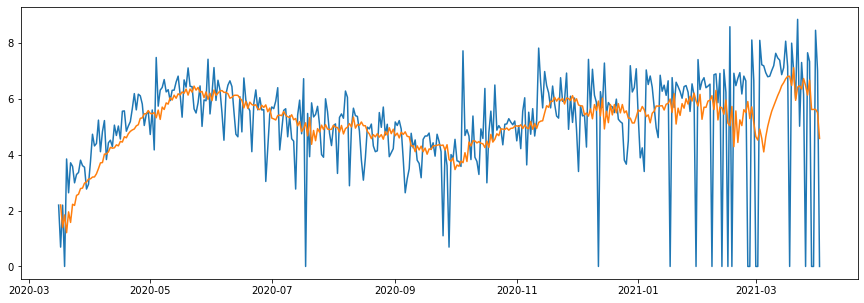

In [40]:
fig, axs = plt.subplots(1, sharex=True, sharey=True,figsize=(15,5))
plt.plot(y_log)
plt.plot(y_pred)

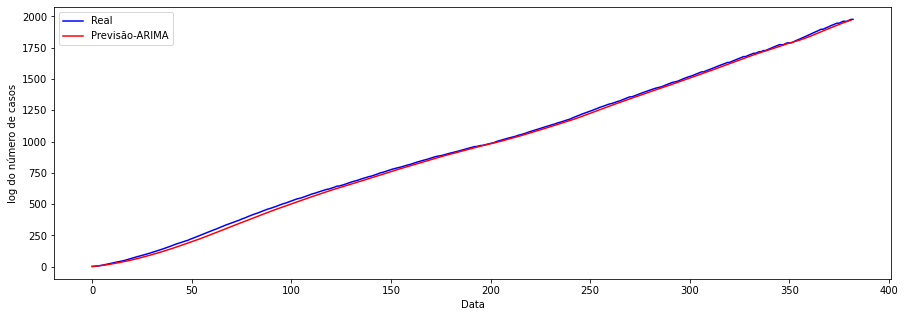

In [44]:
fig, axs = plt.subplots(1, sharex=True, sharey=True,figsize=(15,5))
plt.plot(soma(y_log),label='Real',color='b')
plt.plot(soma(y_pred),color='r',label='Previsão-ARIMA')
plt.xlabel('Data')
plt.ylabel('log do número de casos')
plt.legend()

In [58]:
inicio = np.datetime64('2021-05-05')-np.timedelta64(10,'D')
datas =[]
for i in range(0,30):
   datas.append(inicio+np.timedelta64(i,'D'))

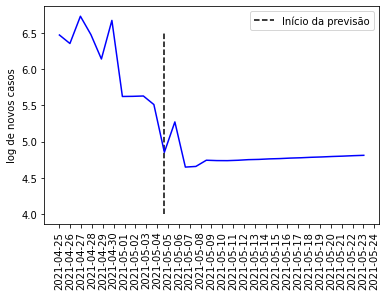

In [87]:
y_futuro = arima(y_log,3,1,2)[1]
x =y_pred[-11:-1]
y = y_futuro
z = np.concatenate((x,y))
plt.plot([10,10],[4,6.5],color='black',linestyle='--',label='Início da previsão')
plt.xticks(np.linspace(0,len(datas),len(datas)),datas,rotation=90)
plt.plot(z,color='b')
plt.ylabel('log de novos casos')
plt.legend()